# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)
LC25000_test_data_au = data_augmentation(LC25000_test_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)
LC25000_test_data_au = np.array(LC25000_test_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)
print("The shape of LC25000_test_data: ", LC25000_test_data_au.shape)
print("The shape of LC25000_test_labels: " ,LC25000_test_labels.shape)

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

125

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train), "rb") as f:
    TCGA_cyclegan_train = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test), "rb") as f:
    TCGA_cyclegan_test = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train['train']
TCGA_cyclegan_train_labels = TCGA_cyclegan_train['train_label']
TCGA_cyclegan_test_data = TCGA_cyclegan_test['test']
TCGA_cyclegan_test_labels = TCGA_cyclegan_test['test_label']

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_train_labels:  (6400,)
The shape of TCGA_cyclegan_test_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_test_labels:  (6400,)


In [ ]:
import gc
gc.collect()

250

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


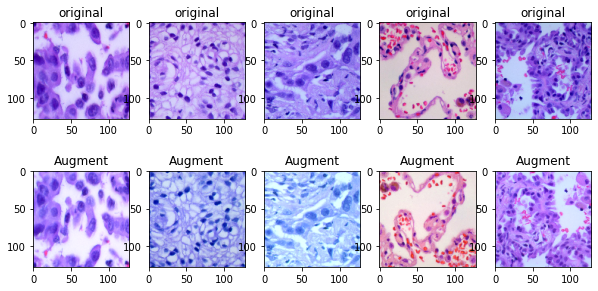

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

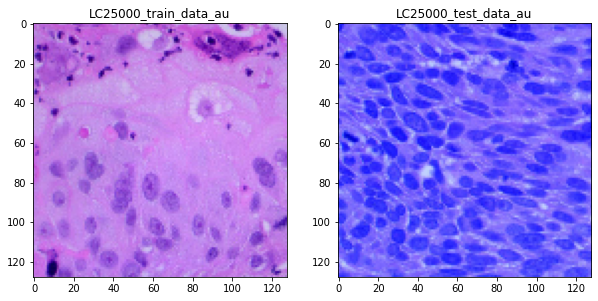

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data_au")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data_au")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

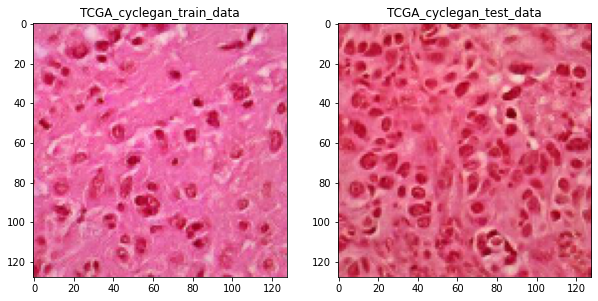

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_128.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 4, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_cyclegan_train_lab = one.transform(np.array(TCGA_cyclegan_train_labels).reshape(-1, 1))

print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data_au (source) shape: (6400, 128, 128, 3)
TCGA_cyclegan_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 6s 27ms/step - loss: 0.7653 - acc: 0.7189 - val_loss: 1.3525 - val_acc: 0.4948
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.4082 - acc: 0.8281 - val_loss: 1.5206 - val_acc: 0.4808
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2949 - acc: 0.8800 - val_loss: 1.6352 - val_acc: 0.4698
Epoch 4/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2431 - acc: 0.9033 - val_loss: 1.7324 - val_acc: 0.4613
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2166 - acc: 0.9166 - val_loss: 1.8517 - val_acc: 0.4564
Epoch 1/100
100/100 [==============================] - 6s 32ms/step - loss: 0.1947 - acc: 0.9273 - val_loss: 1.8074 - val_acc: 0.4519
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1686 - acc: 0.9381 - val_loss: 1.9122 - val_acc: 0.4530
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Run 2

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 24ms/step - loss: 0.7781 - acc: 0.7103 - val_loss: 1.3744 - val_acc: 0.4892
Epoch 2/5
100/100 [==============================] - 2s 17ms/step - loss: 0.4183 - acc: 0.8202 - val_loss: 1.5777 - val_acc: 0.4753
Epoch 3/5
100/100 [==============================] - 2s 17ms/step - loss: 0.3155 - acc: 0.8658 - val_loss: 1.7445 - val_acc: 0.4606
Epoch 4/5
100/100 [==============================] - 2s 17ms/step - loss: 0.2488 - acc: 0.9016 - val_loss: 1.7670 - val_acc: 0.4561
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2230 - acc: 0.9175 - val_loss: 1.9088 - val_acc: 0.4556
Epoch 1/100
100/100 [==============================] - 5s 30ms/step - loss: 0.1993 - acc: 0.9273 - val_loss: 1.8552 - val_acc: 0.4489
Epoch 2/100
100/100 [==============================] - 2s 24ms/step - loss: 0.1773 - acc: 0.9355 - val_loss: 1.9837 - val_acc: 0.4489
Epoch 3/100
100/100 [==============================] - 2s 24ms/step - lo

### Run 3

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 24ms/step - loss: 0.7820 - acc: 0.7066 - val_loss: 1.3304 - val_acc: 0.4973
Epoch 2/5
100/100 [==============================] - 2s 17ms/step - loss: 0.4116 - acc: 0.8245 - val_loss: 1.5027 - val_acc: 0.4812
Epoch 3/5
100/100 [==============================] - 2s 17ms/step - loss: 0.2977 - acc: 0.8777 - val_loss: 1.5972 - val_acc: 0.4684
Epoch 4/5
100/100 [==============================] - 2s 17ms/step - loss: 0.2429 - acc: 0.9030 - val_loss: 1.7016 - val_acc: 0.4617
Epoch 5/5
100/100 [==============================] - 2s 17ms/step - loss: 0.2141 - acc: 0.9197 - val_loss: 1.6966 - val_acc: 0.4536
Epoch 1/100
100/100 [==============================] - 5s 32ms/step - loss: 0.1971 - acc: 0.9273 - val_loss: 1.7136 - val_acc: 0.4525
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1711 - acc: 0.9366 - val_loss: 1.8584 - val_acc: 0.4573
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Run 4

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 24ms/step - loss: 0.7515 - acc: 0.7306 - val_loss: 1.4267 - val_acc: 0.4933
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.4321 - acc: 0.8150 - val_loss: 1.5382 - val_acc: 0.4781
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.3128 - acc: 0.8747 - val_loss: 1.6665 - val_acc: 0.4669
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2450 - acc: 0.9036 - val_loss: 1.7612 - val_acc: 0.4641
Epoch 5/5
100/100 [==============================] - 2s 17ms/step - loss: 0.2167 - acc: 0.9200 - val_loss: 1.7782 - val_acc: 0.4527
Epoch 1/100
100/100 [==============================] - 4s 33ms/step - loss: 0.1903 - acc: 0.9287 - val_loss: 1.8066 - val_acc: 0.4555
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1769 - acc: 0.9359 - val_loss: 1.9152 - val_acc: 0.4541
Epoch 3/100
100/100 [==============================] - 2s 25ms/step - lo

### Run 5

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 23ms/step - loss: 0.7576 - acc: 0.7206 - val_loss: 1.3780 - val_acc: 0.4953
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.4205 - acc: 0.8180 - val_loss: 1.6298 - val_acc: 0.4778
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.3117 - acc: 0.8716 - val_loss: 1.7353 - val_acc: 0.4692
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2521 - acc: 0.9002 - val_loss: 1.8396 - val_acc: 0.4669
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2197 - acc: 0.9147 - val_loss: 1.9624 - val_acc: 0.4584
Epoch 1/100
100/100 [==============================] - 5s 29ms/step - loss: 0.2011 - acc: 0.9222 - val_loss: 1.9451 - val_acc: 0.4552
Epoch 2/100
100/100 [==============================] - 2s 23ms/step - loss: 0.1864 - acc: 0.9275 - val_loss: 1.9980 - val_acc: 0.4552
Epoch 3/100
100/100 [==============================] - 2s 23ms/step - lo

### Result

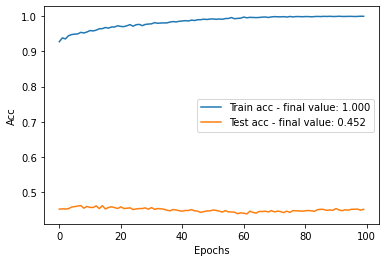

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


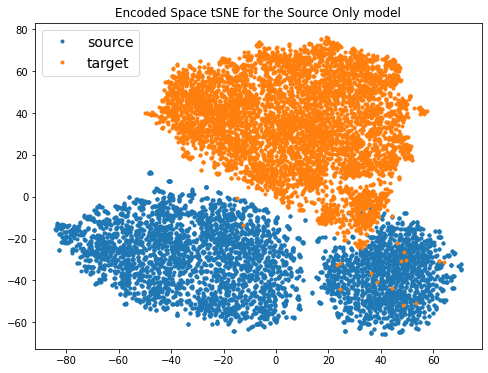

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.043498,0.984108,4.519787,0.449870
std,0.046945,0.017417,1.237121,0.005219
min,0.001079,0.927344,1.807357,0.438437
25%,0.005035,0.974961,3.715387,0.446406
50%,0.024609,0.991250,4.823728,0.449297
75%,0.072206,0.998164,5.536999,0.453477
max,0.194667,0.999687,6.259805,0.462187


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_Resnet_128_Adam_1e-4_AU_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_3 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_3.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 42ms/step - loss: 0.8234 - acc: 0.6791 - disc_loss: 3.8358 - val_loss: 1.0206 - val_acc: 0.4881
Epoch 2/200
100/100 [==============================] - 4s 36ms/step - loss: 0.4130 - acc: 0.8320 - disc_loss: 3.4788 - val_loss: 1.1580 - val_acc: 0.4458
Epoch 3/200
100/100 [==============================] - 4s 36ms/step - loss: 0.3042 - acc: 0.8795 - disc_loss: 3.1081 - val_loss: 1.2790 - val_acc: 0.4448
Epoch 4/200
100/100 [==============================] - 4s 36ms/step - loss: 0.2440 - acc: 0.9053 - disc_loss: 2.7711 - val_loss: 1.4088 - val_acc: 0.4467
Epoch 5/200
100/100 [==============================] - 4s 36ms/step - loss: 0.2164 - acc: 0.9158 - disc_loss: 2.5030 - val_loss: 1.4582 - val_acc: 0.4523
Epoch 6/200
100/100 [==============================] - 4s 36ms/step - loss: 0.2011 - acc: 0.9234 - disc_loss: 2.2797 - val_loss: 1.4790 - val_acc: 0.4617
Epoch 7/200
100/100 [==============================] - 4s 36ms/step - loss: 

### Run 2

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_3 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_3.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 10s 42ms/step - loss: 0.8205 - acc: 0.6817 - disc_loss: 3.8334 - val_loss: 1.0249 - val_acc: 0.4880
Epoch 2/200
100/100 [==============================] - 4s 36ms/step - loss: 0.4149 - acc: 0.8303 - disc_loss: 3.4717 - val_loss: 1.1701 - val_acc: 0.4442
Epoch 3/200
100/100 [==============================] - 4s 36ms/step - loss: 0.3084 - acc: 0.8780 - disc_loss: 3.1108 - val_loss: 1.2847 - val_acc: 0.4428
Epoch 4/200
100/100 [==============================] - 4s 36ms/step - loss: 0.2470 - acc: 0.9038 - disc_loss: 2.7829 - val_loss: 1.4152 - val_acc: 0.4455
Epoch 5/200
100/100 [==============================] - 4s 36ms/step - loss: 0.2196 - acc: 0.9116 - disc_loss: 2.5160 - val_loss: 1.4663 - val_acc: 0.4500
Epoch 6/200
100/100 [==============================] - 4s 36ms/step - loss: 0.2017 - acc: 0.9253 - disc_loss: 2.2976 - val_loss: 1.4805 - val_acc: 0.4603
Epoch 7/200
100/100 [==============================] - 4s 37ms/step - loss:

### Run 3

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_3 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_3.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 41ms/step - loss: 0.0946 - acc: 0.9692 - disc_loss: 5.5967 - val_loss: 4.3866 - val_acc: 0.4670
Epoch 2/200
100/100 [==============================] - 4s 36ms/step - loss: 0.1058 - acc: 0.9711 - disc_loss: 3.4790 - val_loss: 7.1704 - val_acc: 0.4569
Epoch 3/200
100/100 [==============================] - 4s 35ms/step - loss: 0.1018 - acc: 0.9708 - disc_loss: 2.9083 - val_loss: 7.1448 - val_acc: 0.4614
Epoch 4/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0926 - acc: 0.9711 - disc_loss: 2.7163 - val_loss: 8.6211 - val_acc: 0.4569
Epoch 5/200
100/100 [==============================] - 4s 37ms/step - loss: 0.0950 - acc: 0.9686 - disc_loss: 2.7612 - val_loss: 9.3850 - val_acc: 0.4553
Epoch 6/200
100/100 [==============================] - 3s 35ms/step - loss: 0.1416 - acc: 0.9597 - disc_loss: 8.8334 - val_loss: 12.1034 - val_acc: 0.4736
Epoch 7/200
100/100 [==============================] - 4s 37ms/step - loss:

### Run 4

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_3 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_3.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 40ms/step - loss: 0.8227 - acc: 0.6795 - disc_loss: 3.8344 - val_loss: 1.0210 - val_acc: 0.4888
Epoch 2/200
100/100 [==============================] - 3s 34ms/step - loss: 0.4152 - acc: 0.8328 - disc_loss: 3.4754 - val_loss: 1.1657 - val_acc: 0.4442
Epoch 3/200
100/100 [==============================] - 3s 35ms/step - loss: 0.3085 - acc: 0.8798 - disc_loss: 3.1150 - val_loss: 1.2816 - val_acc: 0.4436
Epoch 4/200
100/100 [==============================] - 3s 34ms/step - loss: 0.2471 - acc: 0.9031 - disc_loss: 2.7874 - val_loss: 1.3976 - val_acc: 0.4458
Epoch 5/200
100/100 [==============================] - 3s 34ms/step - loss: 0.2207 - acc: 0.9147 - disc_loss: 2.5121 - val_loss: 1.4469 - val_acc: 0.4525
Epoch 6/200
100/100 [==============================] - 3s 34ms/step - loss: 0.2060 - acc: 0.9219 - disc_loss: 2.2909 - val_loss: 1.4746 - val_acc: 0.4566
Epoch 7/200
100/100 [==============================] - 3s 34ms/step - loss: 

### Run 5

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_3 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_3.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 6s 40ms/step - loss: 0.0867 - acc: 0.9711 - disc_loss: 5.0866 - val_loss: 3.8550 - val_acc: 0.4692
Epoch 2/200
100/100 [==============================] - 3s 34ms/step - loss: 0.0991 - acc: 0.9700 - disc_loss: 3.2992 - val_loss: 4.9469 - val_acc: 0.4617
Epoch 3/200
100/100 [==============================] - 3s 34ms/step - loss: 0.0873 - acc: 0.9720 - disc_loss: 3.0556 - val_loss: 6.7792 - val_acc: 0.4473
Epoch 4/200
100/100 [==============================] - 3s 34ms/step - loss: 0.0927 - acc: 0.9702 - disc_loss: 8.6148 - val_loss: 8.3695 - val_acc: 0.4588
Epoch 5/200
100/100 [==============================] - 3s 34ms/step - loss: 0.1235 - acc: 0.9645 - disc_loss: 24.0372 - val_loss: 8.8335 - val_acc: 0.4627
Epoch 6/200
100/100 [==============================] - 3s 34ms/step - loss: 0.1084 - acc: 0.9652 - disc_loss: 25.2027 - val_loss: 9.3753 - val_acc: 0.4623
Epoch 7/200
100/100 [==============================] - 3s 34ms/step - loss

### Result

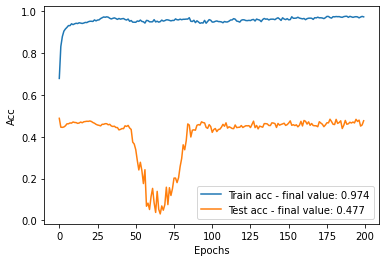

In [ ]:
acc = mdd_3.history.history["acc"]; val_acc = mdd_3.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


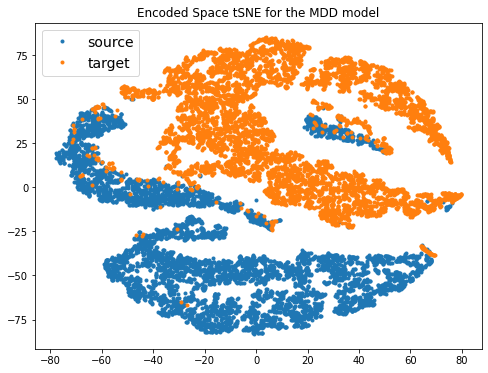

In [ ]:
LC25000_train_data_enc = mdd_3.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd_3.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd_3.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.126491,0.956598,30.230799,3.178050,0.407471
std,0.062891,0.024955,15.160512,1.871750,0.115176
min,0.065487,0.679062,1.629469,1.020562,0.030625
25%,0.097414,0.951836,22.839445,1.898200,0.438750
50%,0.119898,0.959688,37.300884,2.577260,0.453594
75%,0.143528,0.967031,40.878785,3.804934,0.463828
max,0.823410,0.976719,46.829803,10.769855,0.488125


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD/MDD_Resnet_RMS_0.5e-5_g3_AU_cyclegan.csv")

In [ ]:
import gc
gc.collect()

4091